In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
class median_season_length(metrics.BaseMetric):

    def __init__(self, nightCol='night', season_gap=80.,
                 metricName='median_season_length', reduce_func=np.median,
                 **kwargs):
        self.season_gap = season_gap
        self.nightCol = nightCol
        self.reduce_func=reduce_func
        cols = [nightCol]
        super(median_season_length, self).__init__(
            col=cols, metricName=metricName, units='Days', **kwargs)
        pass
    
    def calc_seasons(self, dataslice):
        """
        Method to estimate seasons

        Parameters
        --------------
       obs: numpy array
          array of observations
        season_gap: float, opt
          minimal gap required to define a season (default: 80 days)
        mjdCol: str, opt
          col name for MJD infos (default: observationStartMJD)

        Returns
        ----------
        original numpy array sorted and season 

        """

        dataslice.sort(order=self.nightCol)
        season = np.zeros(dataslice.size, dtype=int)

        if len(dataslice) == 1:
            return season

        diff = dataslice[self.nightCol][1:]-dataslice[self.nightCol][:-1]
        flag = np.where(diff > self.season_gap)[0]
        for i, indx in enumerate(flag):
            season[indx+1:] = i+1

        return season
    def run(self, dataSlice, slicePoint=None):
        seasons = self.calc_seasons(dataSlice)
        u_seasons = np.unique(seasons)
        left = np.searchsorted(seasons, u_seasons, side='left')
        right = np.searchsorted(seasons, u_seasons, side='right')
        season_lengths = dataSlice[self.nightCol][right-1] - dataSlice[self.nightCol][left]
        return self.reduce_func(season_lengths) #np.median(season_lengths)

In [3]:
dbFile = 'baseline_v1.5_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'night', 'fieldDec', 'observationStartMJD'].
Found 2224095 visits
Running:  ['opsim_median_season_length_HEAL', 'opsim_SeasonLength_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 159.361  dipole: lon: 95.087, lat: -80.6243, amp: 26.3572
  mono, lon, lat, amp
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 158.589  dipole: lon: 105.664, lat: -83.8229, amp: 26.5207
  mono, lon, lat, amp


Plotting complete.


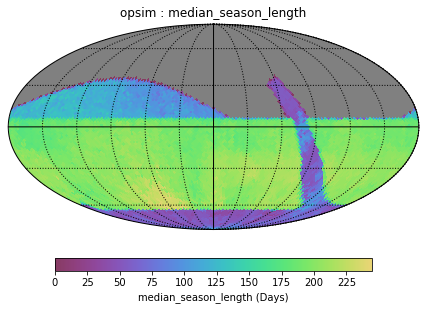

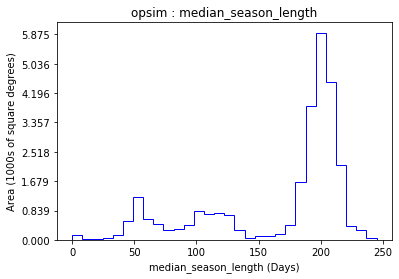

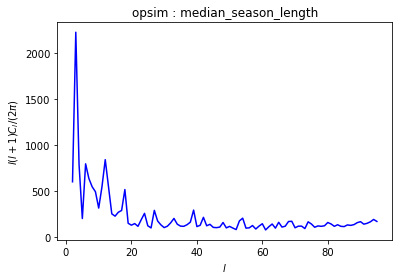

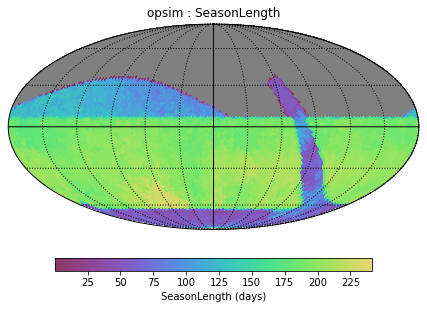

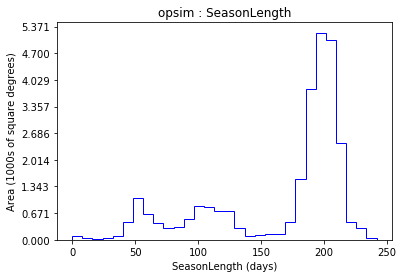

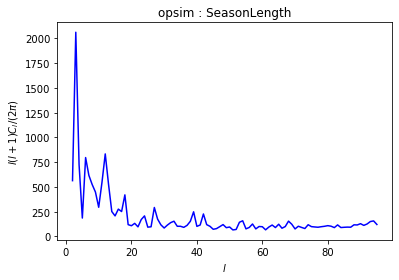

In [4]:
bundleList = []
sql = ''
metric = median_season_length()
slicer = slicers.HealpixSlicer(nside=32)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict))


# and now the classic
metric = metrics.SeasonLengthMetric()
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict))



bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

bg.plotAll(closefigs=False)